# **SEL-NNML Training Visualization - Dataset 1**

This notebook contains visualizations for the SEL-NNML training process, including:
- Training convergence across different samplers (TPE, GP, CMA-ES, QMC)
- Training time comparisons
- Feature importance analysis

## 1. Import Libraries

In [214]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np
import os
from scipy.signal import savgol_filter

## 2. Load Training Histories

In [215]:
# Ensure files exist and load them
base_path = '../artifacts/ds1/models'
files = {
    'TPE': os.path.join(base_path, 'tpe', 'sel-nnml_training_history.csv'),
    'GP': os.path.join(base_path, 'gp', 'sel-nnml_training_history.csv'),
    'CMA-ES': os.path.join(base_path, 'cmaes', 'sel-nnml_training_history.csv'),
    'QMC': os.path.join(base_path, 'qmc', 'sel-nnml_training_history.csv')
}
for k, p in files.items():
    if not os.path.exists(p):
        raise FileNotFoundError(f"Training history file not found: {p}")

tpe_history = pd.read_csv(files['TPE'])
gp_history = pd.read_csv(files['GP'])
cmaes_history = pd.read_csv(files['CMA-ES'])
qmc_history = pd.read_csv(files['QMC'])

print('Training histories loaded successfully!')
print(f"TPE: {tpe_history.shape}, GP: {gp_history.shape}, CMA-ES: {cmaes_history.shape}, QMC: {qmc_history.shape}")

Training histories loaded successfully!
TPE: (100, 2), GP: (100, 2), CMA-ES: (100, 2), QMC: (100, 2)


## 3. Convergence Chart

This chart shows the cumulative best score over iterations for each sampler.

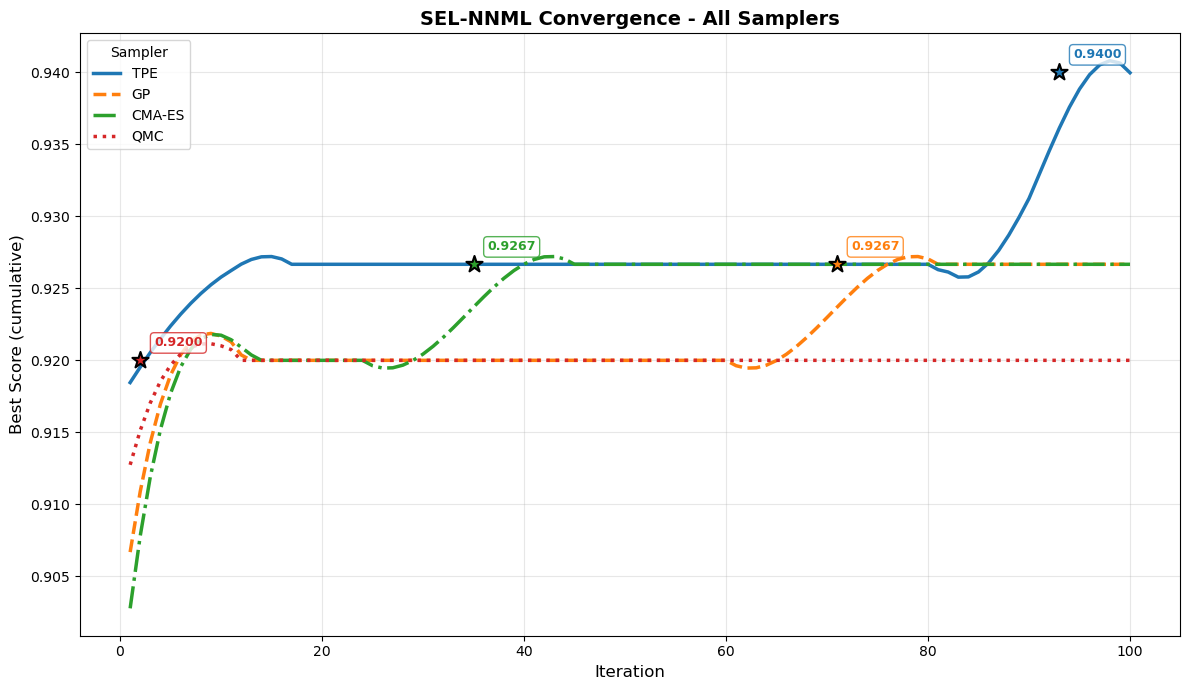

In [216]:
plt.figure(figsize=(12, 7))

samplers = [
    ('TPE', tpe_history, '#1f77b4', '-'),
    ('GP', gp_history, '#ff7f0e', '--'),
    ('CMA-ES', cmaes_history, '#2ca02c', '-.'),
    ('QMC', qmc_history, '#d62728', ':')
]

for name, df, color, linestyle in samplers:
    cumulative_best = df['score'].cummax()
    x = df['iteration'].values
    y = cumulative_best.values
    
    # Apply Savitzky-Golay smoothing
    window_length = min(21, len(y) if len(y) % 2 == 1 else len(y) - 1)
    y_smooth = savgol_filter(y, window_length, 3)
    
    plt.plot(x, y_smooth, label=name, color=color, linewidth=2.5, linestyle=linestyle)
    
    # Highlight peak score
    peak_score = y.max()
    peak_iteration = x[y.argmax()]
    plt.scatter(peak_iteration, peak_score, color=color, s=150, marker='*', 
                edgecolors='black', linewidths=1.5, zorder=5)
    plt.annotate(f'{peak_score:.4f}', 
                xy=(peak_iteration, peak_score),
                xytext=(10, 10), textcoords='offset points',
                fontsize=9, color=color, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor=color, alpha=0.8))

plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Best Score (cumulative)', fontsize=12)
plt.title('SEL-NNML Convergence - All Samplers', fontsize=14, fontweight='bold')
plt.legend(title='Sampler', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Save Convergence Plot

In [217]:
out_dir = '../artifacts/ds1/visualizations'
os.makedirs(out_dir, exist_ok=True)

plt.figure(figsize=(12, 7))
for name, df, color, linestyle in samplers:
    cumulative_best = df['score'].cummax()
    x = df['iteration'].values
    y = cumulative_best.values
    window_length = min(21, len(y) if len(y) % 2 == 1 else len(y) - 1)
    y_smooth = savgol_filter(y, window_length, 3)
    plt.plot(x, y_smooth, label=name, color=color, linewidth=2.5, linestyle=linestyle)
    peak_score = y.max()
    peak_iteration = x[y.argmax()]
    plt.scatter(peak_iteration, peak_score, color=color, s=150, marker='*', 
                edgecolors='black', linewidths=1.5, zorder=5)
    plt.annotate(f'{peak_score:.4f}', xy=(peak_iteration, peak_score),
                xytext=(10, 10), textcoords='offset points', fontsize=9, 
                color=color, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor=color, alpha=0.8))

plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Best Score (cumulative)', fontsize=12)
plt.title('SEL-NNML Convergence - All Samplers', fontsize=14, fontweight='bold')
plt.legend(title='Sampler', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
out_path = os.path.join(out_dir, 'sel_nnml_convergence_all_samplers.png')
plt.savefig(out_path, dpi=300, bbox_inches='tight')
print(f'Convergence plot saved to: {out_path}')
plt.close()

Convergence plot saved to: ../artifacts/ds1/visualizations/sel_nnml_convergence_all_samplers.png


## 5. Training Time Comparison

In [218]:
# Load training times
times_path = '../artifacts/ds1/models/training_times.csv'
times_df = pd.read_csv(times_path)
print("Training Times Loaded:")
print(times_df)

Training Times Loaded:
  Sampler  Base Models Training Time (seconds)  \
0     TPE                            79.417850   
1      GP                           245.867975   
2  CMA-ES                            51.052620   
3     QMC                            50.219519   

   Meta Model Training Time (seconds)  Total Training Time (seconds)  
0                          204.344396                     283.762246  
1                          180.600049                     426.468023  
2                           92.664979                     143.717600  
3                          116.230495                     166.450014  


### 5.1 Training Time Summary Table

In [219]:
def seconds_to_hours(seconds):
    hours = seconds / 3600
    if hours < 0.01:
        minutes = seconds / 60
        return f"{minutes:.2f} min"
    return f"{hours:.4f} hrs"

table_data = []
for _, row in times_df.iterrows():
    table_data.append({
        'Method': row['Sampler'],
        'Base Learner Time': seconds_to_hours(row['Base Models Training Time (seconds)']),
        'Meta Learner Time': seconds_to_hours(row['Meta Model Training Time (seconds)']),
        'Total Time': seconds_to_hours(row['Total Training Time (seconds)'])
    })

summary_table = pd.DataFrame(table_data)
print("\n" + "="*80)
print("TRAINING TIME COMPARISON - SEL-NNML")
print("="*80)
print(summary_table.to_string(index=False))
print("="*80)


TRAINING TIME COMPARISON - SEL-NNML
Method Base Learner Time Meta Learner Time Total Time
   TPE        0.0221 hrs        0.0568 hrs 0.0788 hrs
    GP        0.0683 hrs        0.0502 hrs 0.1185 hrs
CMA-ES        0.0142 hrs        0.0257 hrs 0.0399 hrs
   QMC        0.0139 hrs        0.0323 hrs 0.0462 hrs


### 5.2 Training Time Visualization

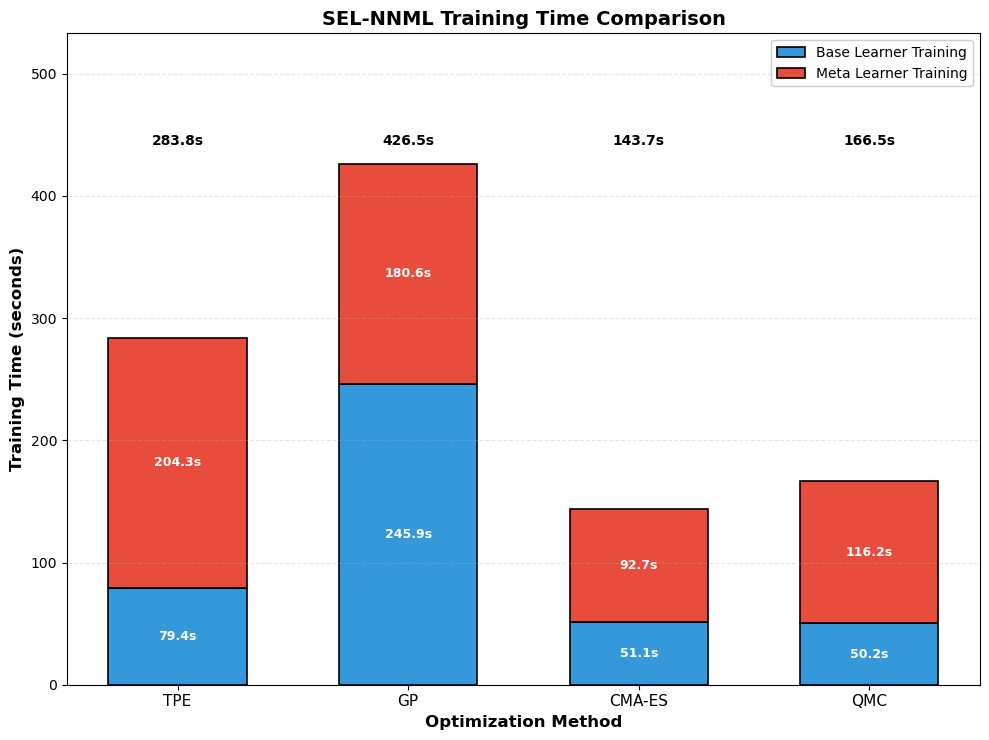

In [220]:
fig, ax = plt.subplots(figsize=(10, 7.5))

samplers_list = times_df['Sampler'].values
base_times = times_df['Base Models Training Time (seconds)'].values
meta_times = times_df['Meta Model Training Time (seconds)'].values

x = np.arange(len(samplers_list))
width = 0.6

bars1 = ax.bar(x, base_times, width, label='Base Learner Training', 
               color='#3498db', edgecolor='black', linewidth=1.2)
bars2 = ax.bar(x, meta_times, width, bottom=base_times, 
               label='Meta Learner Training', color='#e74c3c', edgecolor='black', linewidth=1.2)

max_total = (base_times + meta_times).max()
label_offset = max_total * 0.03

for i, (b, m) in enumerate(zip(base_times, meta_times)):
    total = b + m
    ax.text(i, b/2, f'{b:.1f}s', ha='center', va='center', 
            fontweight='bold', fontsize=9, color='white')
    ax.text(i, b + m/2, f'{m:.1f}s', ha='center', va='center', 
            fontweight='bold', fontsize=9, color='white')
    ax.text(i, max_total + label_offset, f'{total:.1f}s', ha='center', 
            va='bottom', fontweight='bold', fontsize=10)

ax.set_xlabel('Optimization Method', fontsize=12, fontweight='bold')
ax.set_ylabel('Training Time (seconds)', fontsize=12, fontweight='bold')
ax.set_title('SEL-NNML Training Time Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(samplers_list, fontsize=11)
ax.legend(fontsize=10, loc='upper right', framealpha=0.95)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim(0, max_total * 1.25)

plt.tight_layout()
plt.show()

### 5.3 Save Training Time Plot

In [221]:
plt.figure(figsize=(10, 7.5))
x = np.arange(len(samplers_list))
bars1 = plt.bar(x, base_times, width, label='Base Learner Training', 
                color='#3498db', edgecolor='black', linewidth=1.2)
bars2 = plt.bar(x, meta_times, width, bottom=base_times, 
                label='Meta Learner Training', color='#e74c3c', edgecolor='black', linewidth=1.2)

for i, (b, m) in enumerate(zip(base_times, meta_times)):
    total = b + m
    plt.text(i, b/2, f'{b:.1f}s', ha='center', va='center', 
             fontweight='bold', fontsize=9, color='white')
    plt.text(i, b + m/2, f'{m:.1f}s', ha='center', va='center', 
             fontweight='bold', fontsize=9, color='white')
    plt.text(i, max_total + label_offset, f'{total:.1f}s', ha='center', 
             va='bottom', fontweight='bold', fontsize=10)

plt.xlabel('Optimization Method', fontsize=12, fontweight='bold')
plt.ylabel('Training Time (seconds)', fontsize=12, fontweight='bold')
plt.title('SEL-NNML Training Time Comparison', fontsize=14, fontweight='bold')
plt.xticks(x, samplers_list, fontsize=11)
plt.legend(fontsize=10, loc='upper right', framealpha=0.95)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.ylim(0, max_total * 1.25)
plt.tight_layout()

time_plot_path = os.path.join(out_dir, 'sel_nnml_training_times.png')
plt.savefig(time_plot_path, dpi=300, bbox_inches='tight')
print(f'Training time plot saved to: {time_plot_path}')
plt.close()

Training time plot saved to: ../artifacts/ds1/visualizations/sel_nnml_training_times.png


## 6. Feature Importance Visualizations

In [222]:
# Load feature importance data for all samplers
feature_importance = {}
for sampler in ['TPE', 'GP', 'CMA-ES', 'QMC']:
    sampler_folder = sampler.lower().replace("-", "")
    fi_path = f'../artifacts/ds1/models/{sampler_folder}/sel-nnml_feature_importance.csv'
    if os.path.exists(fi_path):
        feature_importance[sampler] = pd.read_csv(fi_path)
        print(f"✓ Loaded {sampler} feature importance: {feature_importance[sampler].shape}")
    else:
        print(f"⚠ Feature importance file not found: {fi_path}")

# Select which sampler to visualize
SELECTED_SAMPLER = 'TPE'
if SELECTED_SAMPLER in feature_importance:
    fi_df = feature_importance[SELECTED_SAMPLER]
    print(f"\nUsing {SELECTED_SAMPLER} for visualizations")
else:
    print(f"⚠ {SELECTED_SAMPLER} data not available")

✓ Loaded TPE feature importance: (18, 3)
✓ Loaded GP feature importance: (18, 3)
✓ Loaded CMA-ES feature importance: (18, 3)
✓ Loaded QMC feature importance: (18, 3)

Using TPE for visualizations


### 6.1 Horizontal Bar Chart with Color Gradient

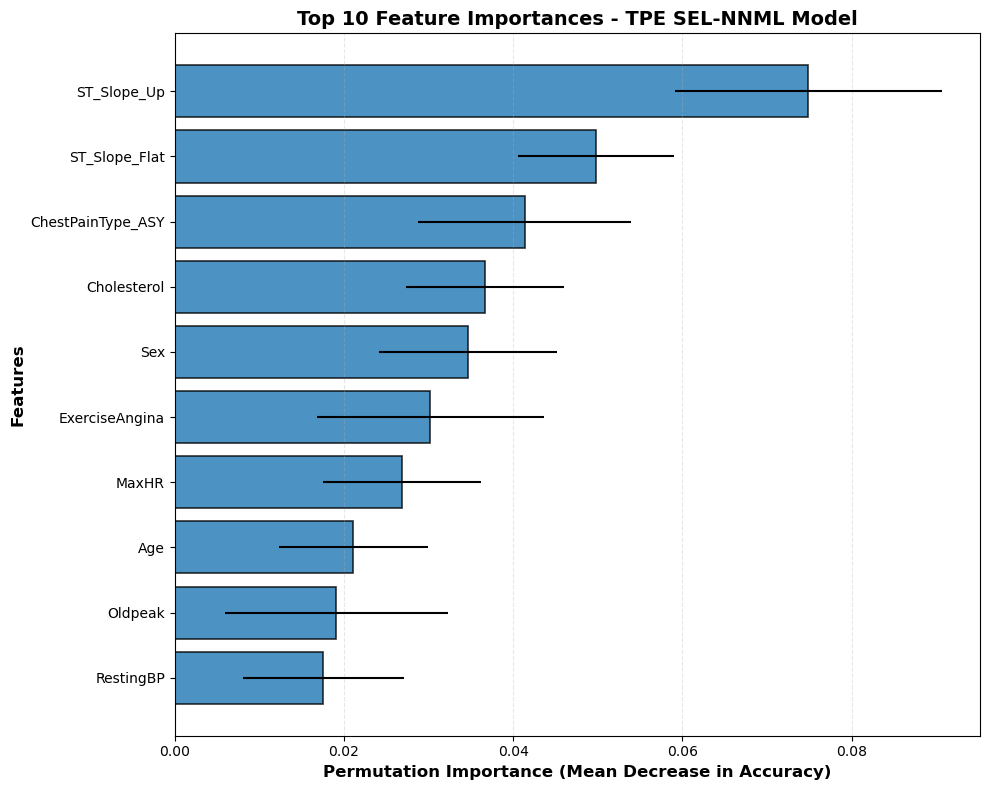

In [223]:
fig, ax = plt.subplots(figsize=(10, 8))

top_n = 10
top_features = fi_df.head(top_n)

y_pos = np.arange(len(top_features))
bars = ax.barh(y_pos, top_features['Importance Mean'].values, 
               xerr=top_features['Importance Std'].values,
               align='center', alpha=0.8, edgecolor='black', linewidth=1.2)

ax.set_yticks(y_pos)
ax.set_yticklabels(top_features['Feature'].values)
ax.invert_yaxis()
ax.set_xlabel('Permutation Importance (Mean Decrease in Accuracy)', fontsize=12, fontweight='bold')
ax.set_ylabel('Features', fontsize=12, fontweight='bold')
ax.set_title(f'Top {top_n} Feature Importances - {SELECTED_SAMPLER} SEL-NNML Model', 
             fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

### 6.2 Cumulative Feature Importance Analysis

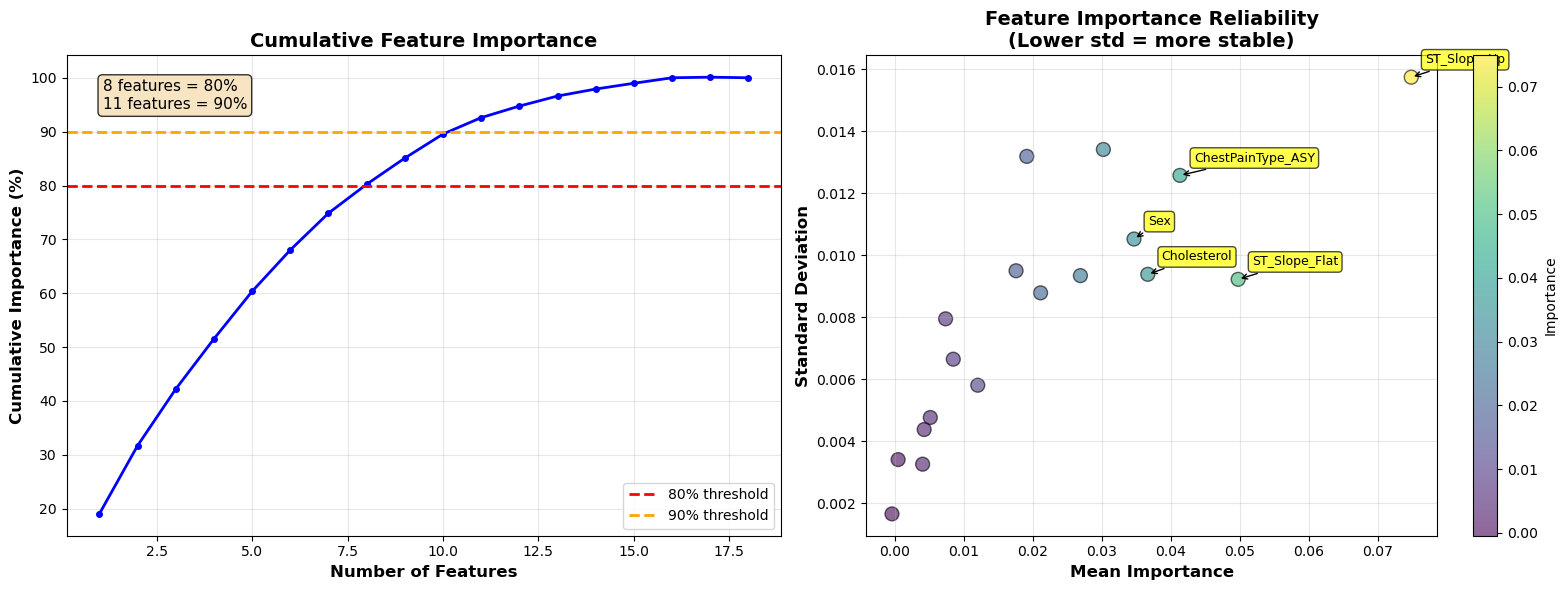

In [224]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left: Cumulative importance
sorted_importance = fi_df.sort_values('Importance Mean', ascending=False)
cumulative_importance = np.cumsum(sorted_importance['Importance Mean'].values)
cumulative_importance_normalized = cumulative_importance / cumulative_importance[-1] * 100

ax1.plot(range(1, len(cumulative_importance_normalized) + 1), cumulative_importance_normalized, 
         'b-', linewidth=2, marker='o', markersize=4, 
         markevery=max(1, len(cumulative_importance_normalized)//20))
ax1.axhline(y=80, color='r', linestyle='--', linewidth=2, label='80% threshold')
ax1.axhline(y=90, color='orange', linestyle='--', linewidth=2, label='90% threshold')
ax1.set_xlabel('Number of Features', fontsize=12, fontweight='bold')
ax1.set_ylabel('Cumulative Importance (%)', fontsize=12, fontweight='bold')
ax1.set_title('Cumulative Feature Importance', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=10)

n_features_80 = np.argmax(cumulative_importance_normalized >= 80) + 1
n_features_90 = np.argmax(cumulative_importance_normalized >= 90) + 1
ax1.text(0.05, 0.95, f'{n_features_80} features = 80%\n{n_features_90} features = 90%',
         transform=ax1.transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Right: Reliability plot
ax2.scatter(fi_df['Importance Mean'], fi_df['Importance Std'],
            alpha=0.6, s=100, c=fi_df['Importance Mean'], cmap='viridis', edgecolors='black')

top_5 = fi_df.head(5)
for idx, row in top_5.iterrows():
    ax2.annotate(row['Feature'], 
                xy=(row['Importance Mean'], row['Importance Std']),
                xytext=(10, 10), textcoords='offset points', fontsize=9,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

ax2.set_xlabel('Mean Importance', fontsize=12, fontweight='bold')
ax2.set_ylabel('Standard Deviation', fontsize=12, fontweight='bold')
ax2.set_title('Feature Importance Reliability\n(Lower std = more stable)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
plt.colorbar(ax2.collections[0], ax=ax2, label='Importance')

plt.tight_layout()
plt.show()

## 7. Cross-Sampler Model Comparison

This section compares model performance across different optimization samplers (TPE, GP, CMA-ES, QMC) to determine which sampler produces the best models.

In [225]:
# Load all models metrics
metrics_path = '../artifacts/ds1/models/all_models_metrics.csv'
all_metrics_df = pd.read_csv(metrics_path)

print("✓ Loaded metrics for all models")
print(f"Total configurations: {len(all_metrics_df)}")
print(f"\nDataset preview:")
display(all_metrics_df.head(10))

✓ Loaded metrics for all models
Total configurations: 32

Dataset preview:


,Sampler,Model,Accuracy,Precision,Recall,F1-Score,AUC
0,TPE,Logistic Regression,0.900000,0.921053,0.886076,0.903226,0.953111
1,TPE,Decision Tree,0.893333,0.909091,0.886076,0.897436,0.935372
2,TPE,Random Forest,0.900000,0.910256,0.898734,0.904459,0.956320
3,TPE,K-Nearest Neighbors,0.913333,0.923077,0.911392,0.917197,0.950793
4,TPE,Support Vector Machine,0.860000,0.926471,0.797468,0.857143,0.959351
5,TPE,AdaBoost,0.893333,0.931507,0.860759,0.894737,0.963986
6,TPE,Gradient Boosting,0.906667,0.945205,0.873418,0.907895,0.965591
7,TPE,SEL-NNML,0.940000,0.948718,0.936709,0.942675,0.963095
8,GP,Logistic Regression,0.893333,0.920000,0.873418,0.896104,0.951328
9,GP,Decision Tree,0.893333,0.909091,0.886076,0.897436,0.935372


### 7.1 Best SEL-NNML Comparison (Across All Samplers)

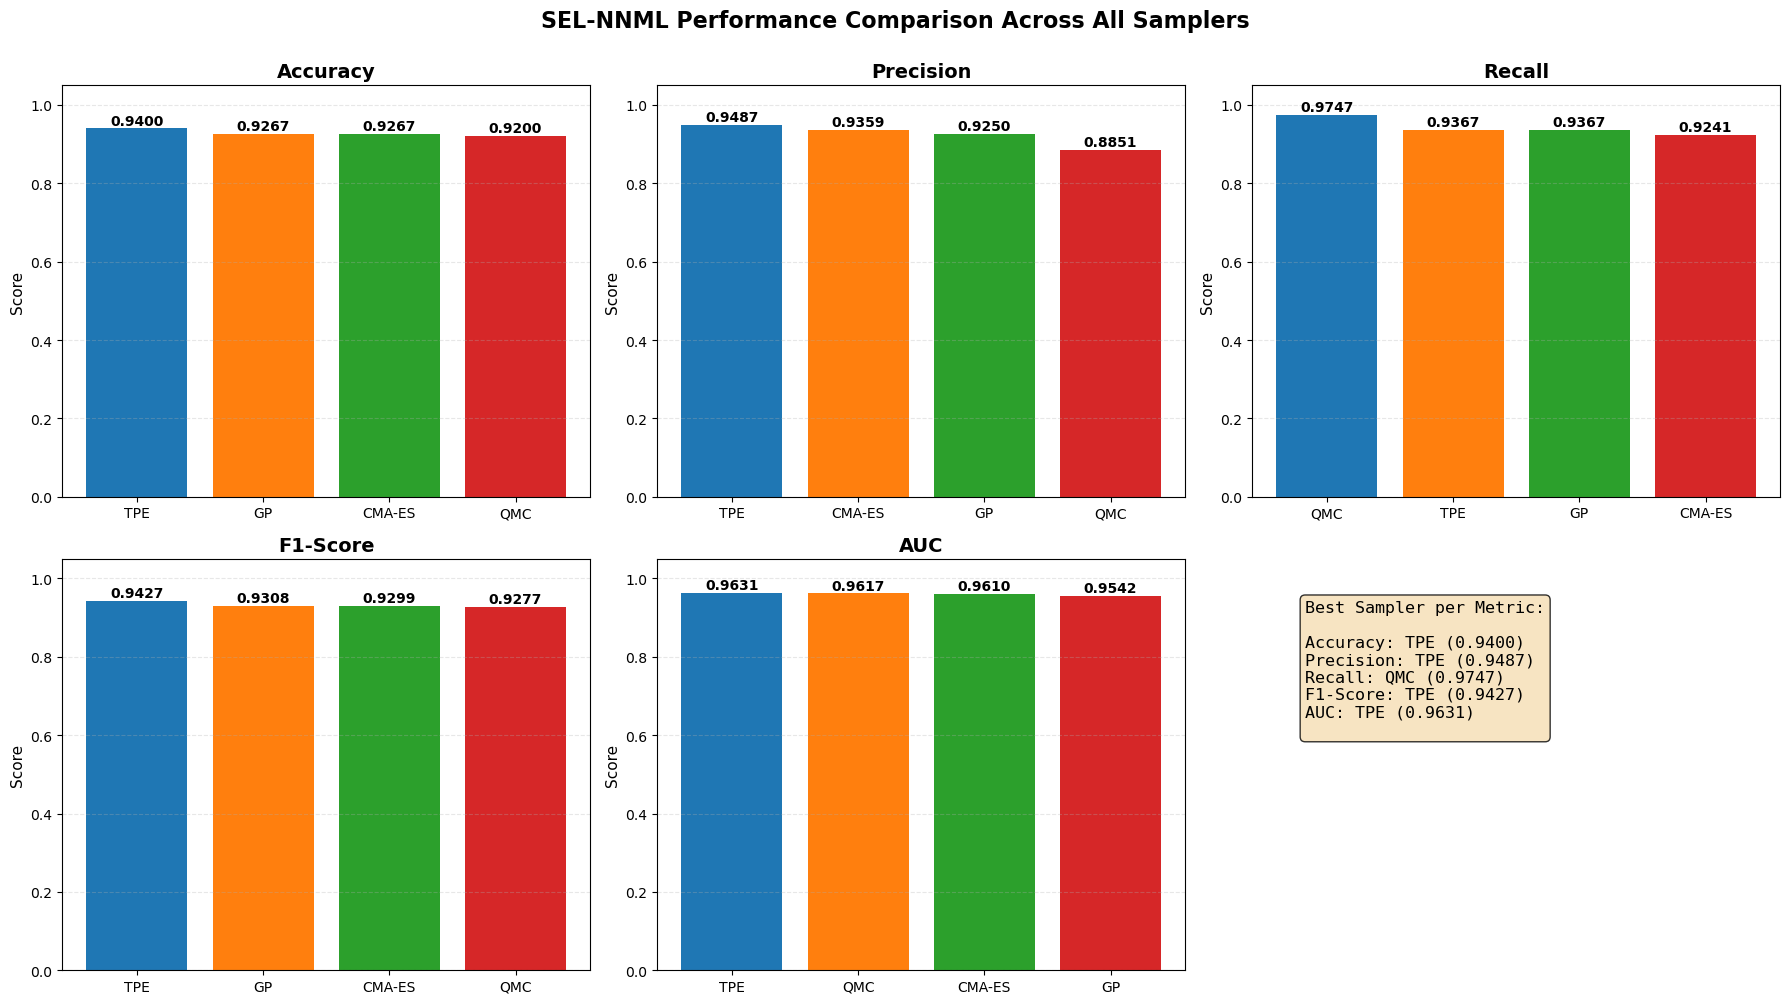

In [226]:
# Compare SEL-NNML models from all samplers
sel_nnml_metrics = all_metrics_df[all_metrics_df['Model'] == 'SEL-NNML'].copy()

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('SEL-NNML Performance Comparison Across All Samplers', fontsize=16, fontweight='bold', y=1.00)

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for idx, metric in enumerate(metrics_to_plot):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    sorted_df = sel_nnml_metrics.sort_values(by=metric, ascending=False)
    bars = ax.bar(sorted_df['Sampler'], sorted_df[metric], color=colors)
    
    ax.set_title(metric, fontsize=14, fontweight='bold')
    ax.set_ylabel('Score', fontsize=11)
    ax.set_ylim([0, 1.05])
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for i, v in enumerate(sorted_df[metric]):
        ax.text(i, v + 0.01, f'{v:.4f}', ha='center', fontsize=10, fontweight='bold')

# Summary table in the last subplot
axes[1, 2].axis('off')
summary_text = "Best Sampler per Metric:\n\n"
for metric in metrics_to_plot:
    best_sampler = sel_nnml_metrics.loc[sel_nnml_metrics[metric].idxmax(), 'Sampler']
    best_value = sel_nnml_metrics[metric].max()
    summary_text += f"{metric}: {best_sampler} ({best_value:.4f})\n"

axes[1, 2].text(0.1, 0.9, summary_text, fontsize=12, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
                family='monospace')

plt.tight_layout()
plt.show()

### 7.2 ROC Curves - All SEL-NNML Models

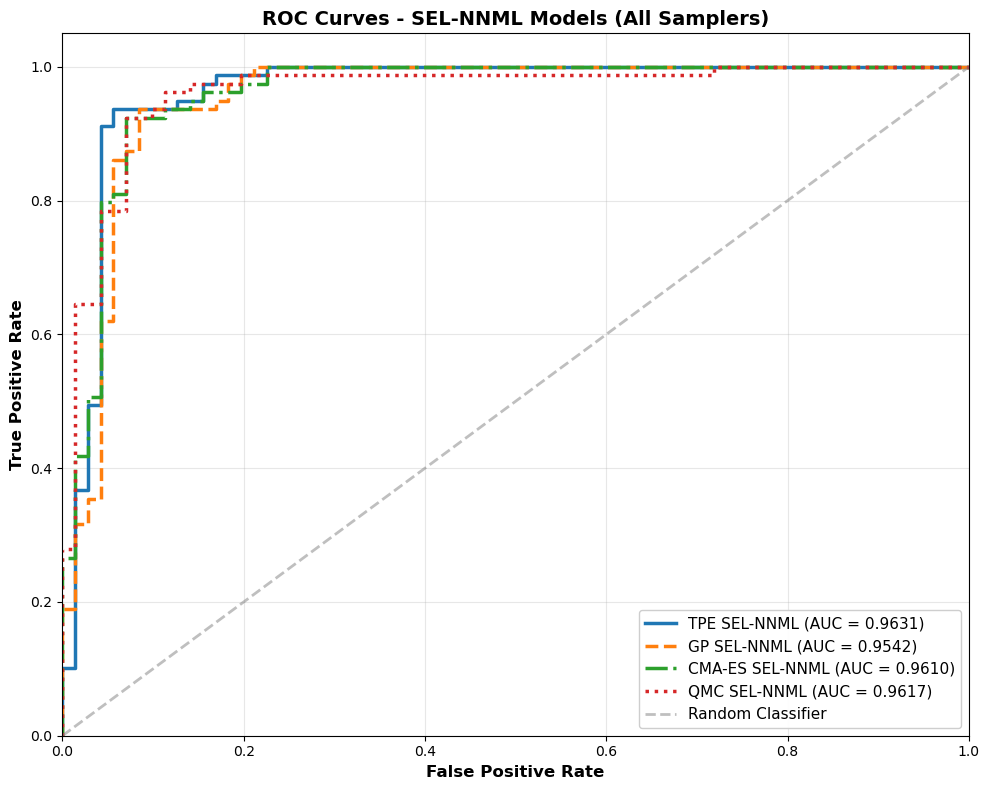

In [227]:
# Load ROC data and plot for SEL-NNML models
roc_path = '../artifacts/ds1/models/all_models_roc_data.csv'
all_roc_df = pd.read_csv(roc_path)

# Filter for SEL-NNML models only
sel_nnml_roc = all_roc_df[all_roc_df['Model'] == 'SEL-NNML']

fig, ax = plt.subplots(figsize=(10, 8))

# Plot ROC curve for each sampler's SEL-NNML
sampler_colors = {'TPE': '#1f77b4', 'GP': '#ff7f0e', 'CMA-ES': '#2ca02c', 'QMC': '#d62728'}
sampler_styles = {'TPE': '-', 'GP': '--', 'CMA-ES': '-.', 'QMC': ':'}

for sampler in ['TPE', 'GP', 'CMA-ES', 'QMC']:
    sampler_data = sel_nnml_roc[sel_nnml_roc['Sampler'] == sampler]
    auc_value = sel_nnml_metrics[sel_nnml_metrics['Sampler'] == sampler]['AUC'].values[0]
    
    ax.plot(sampler_data['FPR'], sampler_data['TPR'], 
            color=sampler_colors[sampler], linestyle=sampler_styles[sampler],
            linewidth=2.5, label=f'{sampler} SEL-NNML (AUC = {auc_value:.4f})')

# Plot diagonal line
ax.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', alpha=0.5, label='Random Classifier')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax.set_title('ROC Curves - SEL-NNML Models (All Samplers)', fontsize=14, fontweight='bold')
ax.legend(loc="lower right", fontsize=11, framealpha=0.95)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 7.3 Performance Heatmap - All Models × All Samplers

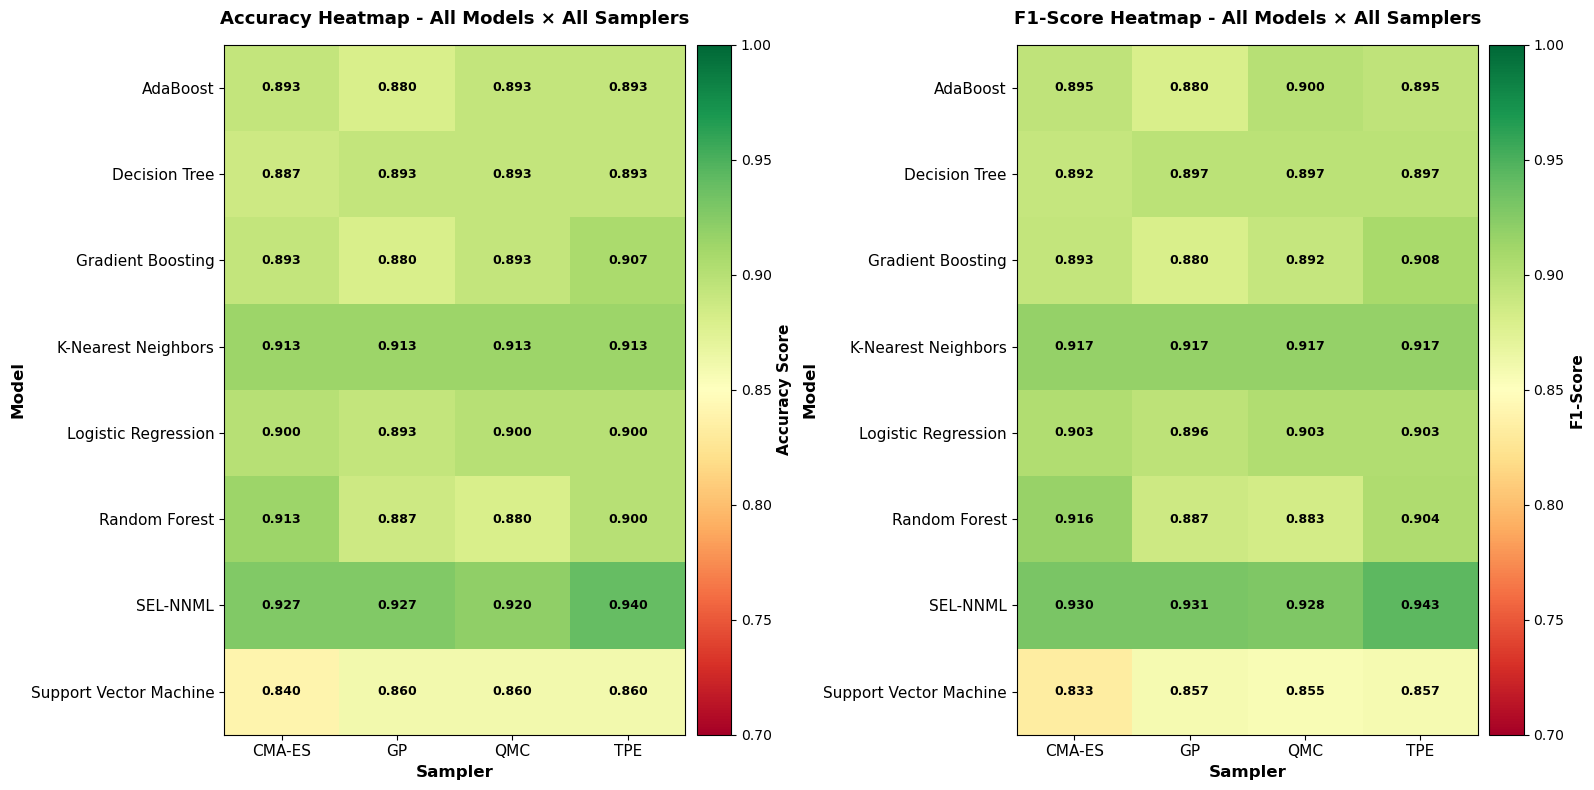

In [228]:
# Create heatmap showing accuracy for all model × sampler combinations
pivot_accuracy = all_metrics_df.pivot(index='Model', columns='Sampler', values='Accuracy')
pivot_f1 = all_metrics_df.pivot(index='Model', columns='Sampler', values='F1-Score')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Accuracy Heatmap
im1 = ax1.imshow(pivot_accuracy.values, cmap='RdYlGn', aspect='auto', vmin=0.7, vmax=1.0)
ax1.set_xticks(np.arange(len(pivot_accuracy.columns)))
ax1.set_yticks(np.arange(len(pivot_accuracy.index)))
ax1.set_xticklabels(pivot_accuracy.columns, fontsize=11)
ax1.set_yticklabels(pivot_accuracy.index, fontsize=11)
ax1.set_title('Accuracy Heatmap - All Models × All Samplers', fontsize=13, fontweight='bold', pad=15)
ax1.set_xlabel('Sampler', fontsize=12, fontweight='bold')
ax1.set_ylabel('Model', fontsize=12, fontweight='bold')

# Add text annotations
for i in range(len(pivot_accuracy.index)):
    for j in range(len(pivot_accuracy.columns)):
        value = pivot_accuracy.values[i, j]
        text = ax1.text(j, i, f'{value:.3f}',
                       ha='center', va='center', color='black', fontsize=9, fontweight='bold')

cbar1 = plt.colorbar(im1, ax=ax1, pad=0.02)
cbar1.set_label('Accuracy Score', fontsize=11, fontweight='bold')

# F1-Score Heatmap
im2 = ax2.imshow(pivot_f1.values, cmap='RdYlGn', aspect='auto', vmin=0.7, vmax=1.0)
ax2.set_xticks(np.arange(len(pivot_f1.columns)))
ax2.set_yticks(np.arange(len(pivot_f1.index)))
ax2.set_xticklabels(pivot_f1.columns, fontsize=11)
ax2.set_yticklabels(pivot_f1.index, fontsize=11)
ax2.set_title('F1-Score Heatmap - All Models × All Samplers', fontsize=13, fontweight='bold', pad=15)
ax2.set_xlabel('Sampler', fontsize=12, fontweight='bold')
ax2.set_ylabel('Model', fontsize=12, fontweight='bold')

# Add text annotations
for i in range(len(pivot_f1.index)):
    for j in range(len(pivot_f1.columns)):
        value = pivot_f1.values[i, j]
        text = ax2.text(j, i, f'{value:.3f}',
                       ha='center', va='center', color='black', fontsize=9, fontweight='bold')

cbar2 = plt.colorbar(im2, ax=ax2, pad=0.02)
cbar2.set_label('F1-Score', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

### 7.4 ROC Curves - All Models (All Samplers)

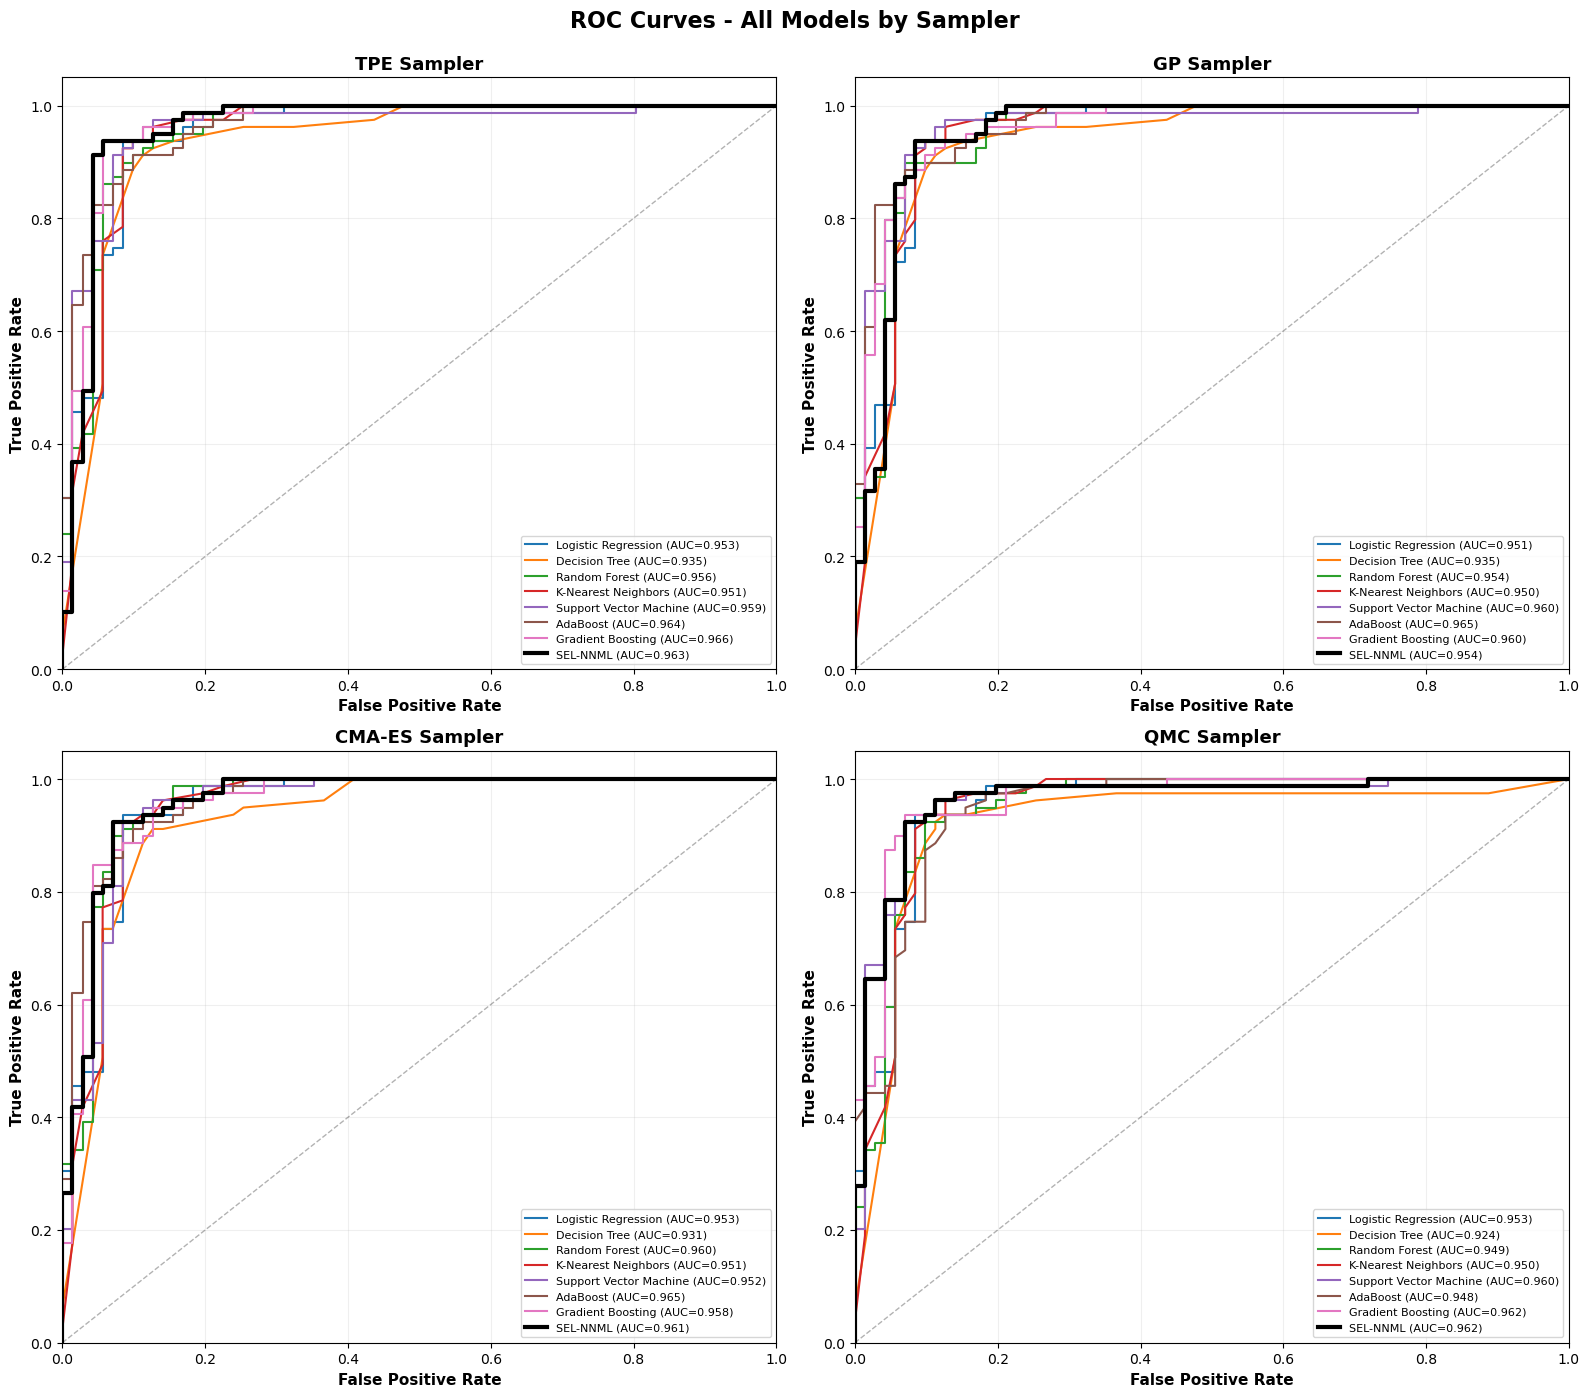

In [229]:
# ROC curves for all models from all samplers in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
fig.suptitle('ROC Curves - All Models by Sampler', fontsize=16, fontweight='bold', y=0.995)

samplers_plot = ['TPE', 'GP', 'CMA-ES', 'QMC']
model_colors = {
    'Logistic Regression': '#1f77b4',
    'Decision Tree': '#ff7f0e',
    'Random Forest': '#2ca02c',
    'K-Nearest Neighbors': '#d62728',
    'Support Vector Machine': '#9467bd',
    'AdaBoost': '#8c564b',
    'Gradient Boosting': '#e377c2',
    'SEL-NNML': '#000000'  # Black for SEL-NNML
}

for idx, sampler in enumerate(samplers_plot):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    # Filter data for this sampler
    sampler_roc = all_roc_df[all_roc_df['Sampler'] == sampler]
    sampler_metrics = all_metrics_df[all_metrics_df['Sampler'] == sampler]
    
    # Plot each model
    for model_name in model_colors.keys():
        model_roc = sampler_roc[sampler_roc['Model'] == model_name]
        model_auc = sampler_metrics[sampler_metrics['Model'] == model_name]['AUC'].values[0]
        
        linewidth = 3 if model_name == 'SEL-NNML' else 1.5
        ax.plot(model_roc['FPR'], model_roc['TPR'],
                color=model_colors[model_name], linewidth=linewidth,
                label=f'{model_name} (AUC={model_auc:.3f})')
    
    # Plot diagonal
    ax.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.3)
    
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=11, fontweight='bold')
    ax.set_ylabel('True Positive Rate', fontsize=11, fontweight='bold')
    ax.set_title(f'{sampler} Sampler', fontsize=13, fontweight='bold')
    ax.legend(loc="lower right", fontsize=8)
    ax.grid(alpha=0.2)

plt.tight_layout()
plt.show()

### 7.5 Save Cross-Sampler Comparison Plots

In [230]:
viz_dir = '../artifacts/ds1/visualizations'
os.makedirs(viz_dir, exist_ok=True)

# 1. Save SEL-NNML comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('SEL-NNML Performance Comparison Across All Samplers', fontsize=16, fontweight='bold', y=1.00)
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for idx, metric in enumerate(metrics_to_plot):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    sorted_df = sel_nnml_metrics.sort_values(by=metric, ascending=False)
    bars = ax.bar(sorted_df['Sampler'], sorted_df[metric], color=colors)
    ax.set_title(metric, fontsize=14, fontweight='bold')
    ax.set_ylabel('Score', fontsize=11)
    ax.set_ylim([0, 1.05])
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    for i, v in enumerate(sorted_df[metric]):
        ax.text(i, v + 0.01, f'{v:.4f}', ha='center', fontsize=10, fontweight='bold')

axes[1, 2].axis('off')
summary_text = "Best Sampler per Metric:\n\n"
for metric in metrics_to_plot:
    best_sampler = sel_nnml_metrics.loc[sel_nnml_metrics[metric].idxmax(), 'Sampler']
    best_value = sel_nnml_metrics[metric].max()
    summary_text += f"{metric}: {best_sampler} ({best_value:.4f})\n"
axes[1, 2].text(0.1, 0.9, summary_text, fontsize=12, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8), family='monospace')
plt.tight_layout()
sel_nnml_comp_path = os.path.join(viz_dir, 'cross_sampler_sel_nnml_comparison.png')
plt.savefig(sel_nnml_comp_path, dpi=300, bbox_inches='tight')
print(f'✓ SEL-NNML comparison saved to: {sel_nnml_comp_path}')
plt.close()

# 2. Save SEL-NNML ROC curves
fig, ax = plt.subplots(figsize=(10, 8))
sampler_colors = {'TPE': '#1f77b4', 'GP': '#ff7f0e', 'CMA-ES': '#2ca02c', 'QMC': '#d62728'}
sampler_styles = {'TPE': '-', 'GP': '--', 'CMA-ES': '-.', 'QMC': ':'}
for sampler in ['TPE', 'GP', 'CMA-ES', 'QMC']:
    sampler_data = sel_nnml_roc[sel_nnml_roc['Sampler'] == sampler]
    auc_value = sel_nnml_metrics[sel_nnml_metrics['Sampler'] == sampler]['AUC'].values[0]
    ax.plot(sampler_data['FPR'], sampler_data['TPR'], 
            color=sampler_colors[sampler], linestyle=sampler_styles[sampler],
            linewidth=2.5, label=f'{sampler} SEL-NNML (AUC = {auc_value:.4f})')
ax.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', alpha=0.5, label='Random Classifier')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax.set_title('ROC Curves - SEL-NNML Models (All Samplers)', fontsize=14, fontweight='bold')
ax.legend(loc="lower right", fontsize=11, framealpha=0.95)
ax.grid(alpha=0.3)
plt.tight_layout()
sel_nnml_roc_path = os.path.join(viz_dir, 'cross_sampler_sel_nnml_roc.png')
plt.savefig(sel_nnml_roc_path, dpi=300, bbox_inches='tight')
print(f'✓ SEL-NNML ROC curves saved to: {sel_nnml_roc_path}')
plt.close()

# 3. Save heatmaps
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
im1 = ax1.imshow(pivot_accuracy.values, cmap='RdYlGn', aspect='auto', vmin=0.7, vmax=1.0)
ax1.set_xticks(np.arange(len(pivot_accuracy.columns)))
ax1.set_yticks(np.arange(len(pivot_accuracy.index)))
ax1.set_xticklabels(pivot_accuracy.columns, fontsize=11)
ax1.set_yticklabels(pivot_accuracy.index, fontsize=11)
ax1.set_title('Accuracy Heatmap - All Models × All Samplers', fontsize=13, fontweight='bold', pad=15)
ax1.set_xlabel('Sampler', fontsize=12, fontweight='bold')
ax1.set_ylabel('Model', fontsize=12, fontweight='bold')
for i in range(len(pivot_accuracy.index)):
    for j in range(len(pivot_accuracy.columns)):
        ax1.text(j, i, f'{pivot_accuracy.values[i, j]:.3f}',
               ha='center', va='center', color='black', fontsize=9, fontweight='bold')
cbar1 = plt.colorbar(im1, ax=ax1, pad=0.02)
cbar1.set_label('Accuracy Score', fontsize=11, fontweight='bold')

im2 = ax2.imshow(pivot_f1.values, cmap='RdYlGn', aspect='auto', vmin=0.7, vmax=1.0)
ax2.set_xticks(np.arange(len(pivot_f1.columns)))
ax2.set_yticks(np.arange(len(pivot_f1.index)))
ax2.set_xticklabels(pivot_f1.columns, fontsize=11)
ax2.set_yticklabels(pivot_f1.index, fontsize=11)
ax2.set_title('F1-Score Heatmap - All Models × All Samplers', fontsize=13, fontweight='bold', pad=15)
ax2.set_xlabel('Sampler', fontsize=12, fontweight='bold')
ax2.set_ylabel('Model', fontsize=12, fontweight='bold')
for i in range(len(pivot_f1.index)):
    for j in range(len(pivot_f1.columns)):
        ax2.text(j, i, f'{pivot_f1.values[i, j]:.3f}',
               ha='center', va='center', color='black', fontsize=9, fontweight='bold')
cbar2 = plt.colorbar(im2, ax=ax2, pad=0.02)
cbar2.set_label('F1-Score', fontsize=11, fontweight='bold')
plt.tight_layout()
heatmap_path = os.path.join(viz_dir, 'cross_sampler_heatmaps.png')
plt.savefig(heatmap_path, dpi=300, bbox_inches='tight')
print(f'✓ Performance heatmaps saved to: {heatmap_path}')
plt.close()

# 4. Save all models ROC curves
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
fig.suptitle('ROC Curves - All Models by Sampler', fontsize=16, fontweight='bold', y=0.995)
samplers_plot = ['TPE', 'GP', 'CMA-ES', 'QMC']
model_colors = {
    'Logistic Regression': '#1f77b4', 'Decision Tree': '#ff7f0e', 'Random Forest': '#2ca02c',
    'K-Nearest Neighbors': '#d62728', 'Support Vector Machine': '#9467bd',
    'AdaBoost': '#8c564b', 'Gradient Boosting': '#e377c2', 'SEL-NNML': '#000000'
}

for idx, sampler in enumerate(samplers_plot):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    sampler_roc = all_roc_df[all_roc_df['Sampler'] == sampler]
    sampler_metrics = all_metrics_df[all_metrics_df['Sampler'] == sampler]
    for model_name in model_colors.keys():
        model_roc = sampler_roc[sampler_roc['Model'] == model_name]
        model_auc = sampler_metrics[sampler_metrics['Model'] == model_name]['AUC'].values[0]
        linewidth = 3 if model_name == 'SEL-NNML' else 1.5
        ax.plot(model_roc['FPR'], model_roc['TPR'],
                color=model_colors[model_name], linewidth=linewidth,
                label=f'{model_name} (AUC={model_auc:.3f})')
    ax.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.3)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=11, fontweight='bold')
    ax.set_ylabel('True Positive Rate', fontsize=11, fontweight='bold')
    ax.set_title(f'{sampler} Sampler', fontsize=13, fontweight='bold')
    ax.legend(loc="lower right", fontsize=8)
    ax.grid(alpha=0.2)
plt.tight_layout()
all_roc_path = os.path.join(viz_dir, 'cross_sampler_all_models_roc.png')
plt.savefig(all_roc_path, dpi=300, bbox_inches='tight')
print(f'✓ All models ROC curves saved to: {all_roc_path}')
plt.close()

print(f'\n✅ All cross-sampler comparison plots saved to {viz_dir}')

✓ SEL-NNML comparison saved to: ../artifacts/ds1/visualizations/cross_sampler_sel_nnml_comparison.png
✓ SEL-NNML ROC curves saved to: ../artifacts/ds1/visualizations/cross_sampler_sel_nnml_roc.png
✓ SEL-NNML ROC curves saved to: ../artifacts/ds1/visualizations/cross_sampler_sel_nnml_roc.png
✓ Performance heatmaps saved to: ../artifacts/ds1/visualizations/cross_sampler_heatmaps.png
✓ Performance heatmaps saved to: ../artifacts/ds1/visualizations/cross_sampler_heatmaps.png
✓ All models ROC curves saved to: ../artifacts/ds1/visualizations/cross_sampler_all_models_roc.png

✅ All cross-sampler comparison plots saved to ../artifacts/ds1/visualizations
✓ All models ROC curves saved to: ../artifacts/ds1/visualizations/cross_sampler_all_models_roc.png

✅ All cross-sampler comparison plots saved to ../artifacts/ds1/visualizations
